In [1]:
import pyart
import numpy as np
import os, sys
import pylops
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# add location of local leroy modules to sys.path and import them
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('leroy.py'))))
import leroy 
import qc 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Quality Control

In [2]:
field = 'VRADH'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    #radar = pyart.io.read("/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/20021124/twp10cpolppi.b1.20021124.110000.nc")
    radar = pyart.aux_io.read_odim_h5('/home/jordan/dev/HT_WORK/Data/20201031/66_20201031_050028.pvol.h5', file_field_names=True)
    radar.add_field_like(field, field+'_original', radar.fields[field]['data'])
    radar = qc.mask_invalid_data(radar, 'DBZH', add_to = [field], min_field = 5, min_area = 50, return_smooth = False)

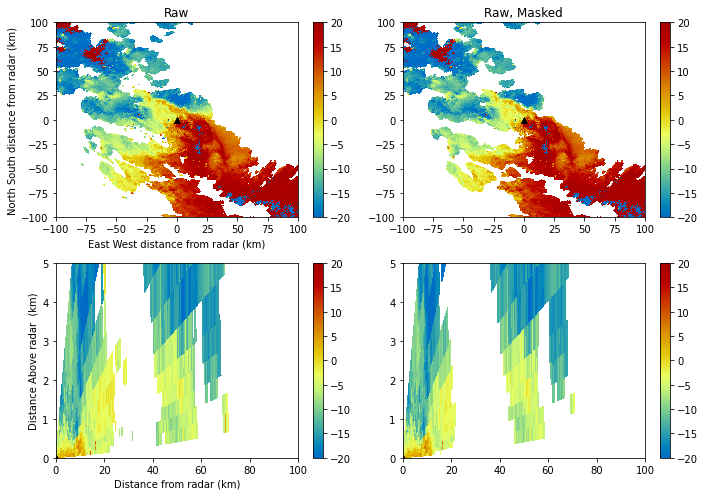

In [3]:
# create the plot using RadarDisplay
gb = ((0,5), (-100,100), (-100,100))
rlim = (0,100)
tilt, ray, vmin, vmax = 1,236, -20, 20

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(221)
ax.plot(0,0, 'k^')
display.plot_ppi(field+'_original', tilt, ax=ax,colorbar_flag= True,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

ax = fig.add_subplot(222)
ax.plot(0,0, 'k^')

display.plot_ppi(field+'', tilt, ax=ax,colorbar_flag= True, axislabels_flag = False,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw, Masked',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

xsect = pyart.util.cross_section_ppi(radar, [ray])
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(223)
ax.plot(0,0, 'k^')

display.plot(field+'_original', 0, colorbar_flag= True, vmin = vmin, vmax = vmax,colorbar_label='',
             title=  '',cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(224)
ax.plot(0,0, 'k^')

display.plot(field+'', 0, colorbar_flag= True, vmin = vmin, vmax = vmax, title=  '',colorbar_label='',
             axislabels_flag = False,cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)

plt.tight_layout()
plt.show()

# Gridding

In [4]:
gs = (25, 201, 201)
gb = ((0, 12000), (-100000,100000),(-100000,100000))
center_pos = (0,0,0)

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])

field = 'VRADH'

def leroy_grid(radar,coords, field):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        return leroy.cressman_ppi_interp(radar, coords, 1200, field, k=200, verbose=True, filter_its = 1)

In [5]:
vrad = leroy_grid(radar,coords, field)

Interpolating...
Filtering...
Done!


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/jordan/anaconda3/envs/pyartenv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


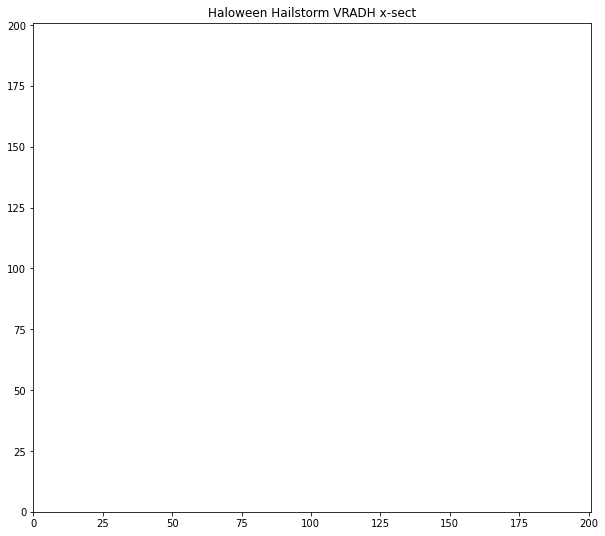

In [6]:
zidx = 5
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
ax.pcolormesh(vrad[zidx,...], cmap ='pyart_HomeyerRainbow')
plt.title('Haloween Hailstorm VRADH x-sect')
plt.show()

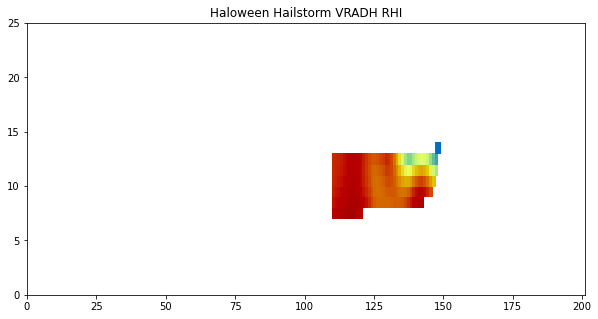

In [7]:
yidx = 70
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.pcolormesh(vrad[:,yidx,:], cmap ='pyart_HomeyerRainbow')
plt.title('Haloween Hailstorm VRADH RHI')
plt.show()